# Computing PET

In [1]:
import calendar
from pathlib import Path

import geopandas as gpd
import pandas as pd
import pydaymet as daymet
import xarray as xr

`PyDaymet` offers three methods for computing PET: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's compute PET using `PyDaymet` with these three methods and compare them with
the [CAMELS](https://ral.ucar.edu/solutions/products/camels).

We choose station ID of 01013500 and time period of 2000-01-01 to 2009-01-12.

In [2]:
station = "01013500"
coords = (-68.58264, 47.23739)
dates = ("2000-01-01", "2009-01-12")
root = Path("input_data")

In [3]:
clm_par = Path(root, f"{station}_clm_single_pixel.parquet")
clm_nc = Path(root, f"{station}_clm_basin.nc")
basin = gpd.read_feather(Path(root, f"{station}_basin.feather"))

if clm_par.exists() and clm_nc.exists():
    clm_c = pd.read_parquet(clm_par)
    clm_b = xr.open_dataset(clm_nc)
else:
    clm_c = daymet.get_bycoords(coords, dates)
    clm_b = daymet.get_bygeom(basin.geometry[0], dates)
    clm_c.to_parquet(clm_par)
    clm_b.to_netcdf(clm_nc)

In [4]:
single, gridded = {}, {}
methods = {"HS": "hargreaves_samani", "PM": "penman_monteith", "PT": "priestley_taylor"}
for n, m in methods.items():
    pet_c = daymet.potential_et(clm_c, coords, method=m)
    single[f"{n} (Single Pixel)"] = pet_c["pet (mm/day)"]
    pet_b = daymet.potential_et(clm_b, method=m)
    gridded[f"{n} (Areal Average)"] = pet_b.pet.mean(dim=["x", "y"]).values

Now, let's get the CAMELS dataset and extract PET for our target station and time period.

In [5]:
camels = pd.read_parquet(Path(root, f"{station}_05_model_output.parquet"))
camels = camels.loc[clm_c.index, "PET"]

In [6]:
pet = pd.DataFrame({**single, **gridded, "CAMELS": camels})
pet[pet.lt(0)] = 0.0

We can plot the data for daily and mean-monthly PET.

<AxesSubplot:ylabel='PET (mm/day)'>

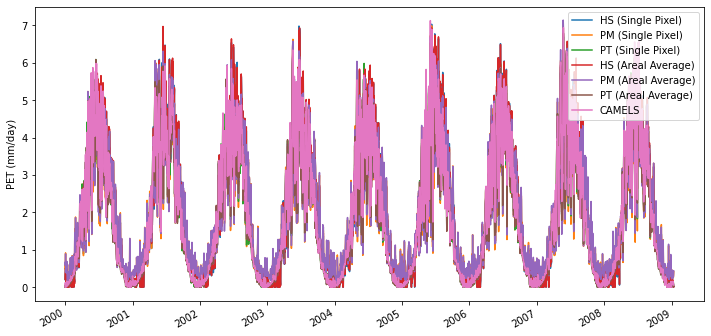

In [7]:
pet.plot(figsize=(12, 6), ylabel="PET (mm/day)")

In [8]:
month_abbr = dict(enumerate(calendar.month_abbr))
mean_month = pet.groupby(pet.index.month).mean()
mean_month.index = mean_month.index.map(month_abbr)

<AxesSubplot:ylabel='PET (mm/month)'>

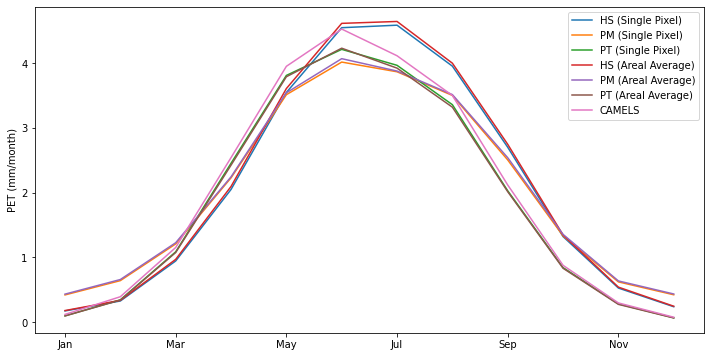

In [9]:
mean_month.plot(figsize=(12, 6), ylabel="PET (mm/month)")